# Importing Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, auc
import os

# Loading Image Dataset

In [2]:
BATCH_SIZE = 32  
IMAGE_SIZE = 256    
channels = 3         
epochs =  50

In [3]:
# Loading Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
"aloevera",
 shuffle = True,
 image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)


Found 3495 files belonging to 3 classes.


# Exploring Dataset

In [4]:
print(len(list(dataset)))

110


In [5]:
class_names = dataset.class_names
class_names

['healthy_leaf', 'rot', 'rust']

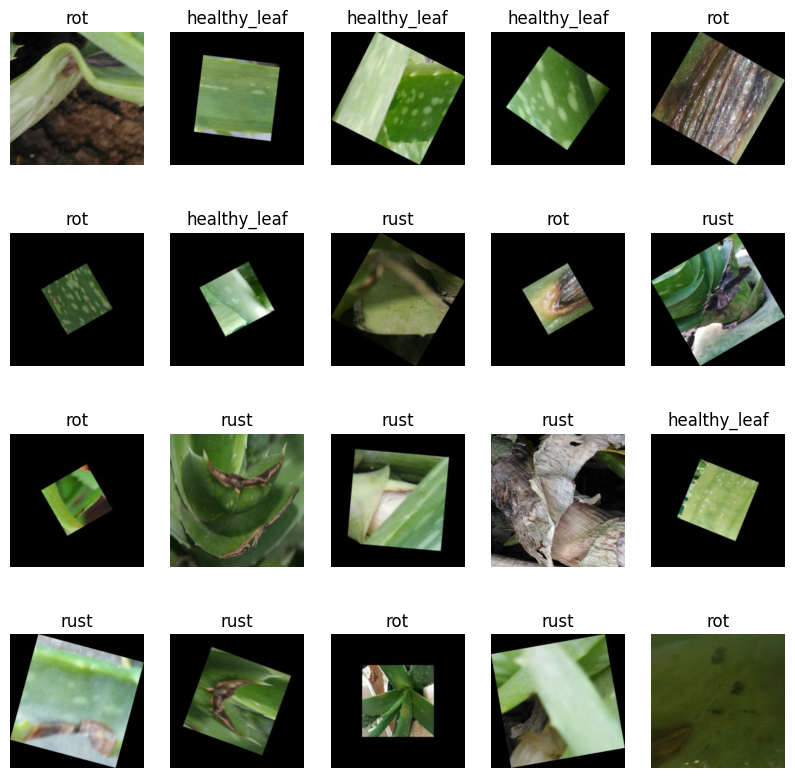

In [6]:
plt.figure(figsize =(10,10)) 
for image_batch, labels_batch in dataset.take(1):
    for i in range(20):
        axs = plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis('off')

# TRAINING AND TESTING DATA

In [7]:
#Spliting Function
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size= 10000):
    assert(train_split+val_split+test_split) == 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, validation_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)    
val_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Image Pre-Processing

In [10]:
# Re-Scaling and Normalizing the Images
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
]
)

In [11]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomRotation(0.3)
]
)

# BUILDING A CNN MODEL

In [12]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),   
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),     
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),       
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),       
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),       
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),       
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
]
)   
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [14]:
model.compile(
optimizer='adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

In [19]:
history = model.fit(
    train_ds,
    batch_size =BATCH_SIZE,
     validation_data = val_ds,
     verbose =1,
     epochs = epochs)

Epoch 1/50
88/88 [==============================] - 233s 2s/step - loss: 0.9471 - accuracy: 0.5306 - val_loss: 0.8663 - val_accuracy: 0.6193
Epoch 2/50
88/88 [==============================] - 230s 3s/step - loss: 0.6873 - accuracy: 0.6804 - val_loss: 0.5511 - val_accuracy: 0.7699
Epoch 3/50
88/88 [==============================] - 207s 2s/step - loss: 0.5072 - accuracy: 0.7854 - val_loss: 0.4691 - val_accuracy: 0.8040
Epoch 4/50
88/88 [==============================] - 231s 3s/step - loss: 0.4192 - accuracy: 0.8280 - val_loss: 0.3975 - val_accuracy: 0.8409
Epoch 5/50
88/88 [==============================] - 224s 3s/step - loss: 0.4161 - accuracy: 0.8262 - val_loss: 0.3952 - val_accuracy: 0.8352
Epoch 6/50
88/88 [==============================] - 226s 3s/step - loss: 0.3731 - accuracy: 0.8449 - val_loss: 0.3568 - val_accuracy: 0.8352
Epoch 7/50
88/88 [==============================] - 210s 2s/step - loss: 0.3379 - accuracy: 0.8574 - val_loss: 0.3107 - val_accuracy: 0.8636
Epoch 8/50
88

# Evaluating the Model

In [47]:
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to make predictions
for images, labels in validation_ds:
    predictions = model.predict(images)
    predicted_labels.extend(tf.argmax(predictions, axis=1).numpy())
    true_labels.extend(labels.numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='micro')
recall = recall_score(true_labels, predicted_labels, average='micro')
f1 = f1_score(true_labels, predicted_labels, average='micro')

# Print the evaluation metrics
print("---------------------------------")
print("EVALUAITON Metrics")
print(f'Accuracy: {round((accuracy)*100,2)}%')
print(f'Precision: {round((precision)*100,2)}%')
print(f'Recall: {round((recall)*100,2)}%')
print(f'F1-Score: {round((f1)*100,2)}%')

1/1 [==============================] - 0s 483ms/step
---------------------------------
EVALUAITON Metrics
Accuracy: 98.58%
Precision: 98.58%
Recall: 98.58%
F1-Score: 98.58%


# Plot Training History on Graph

Text(0.5, 1.0, 'Training and Validation Loss')

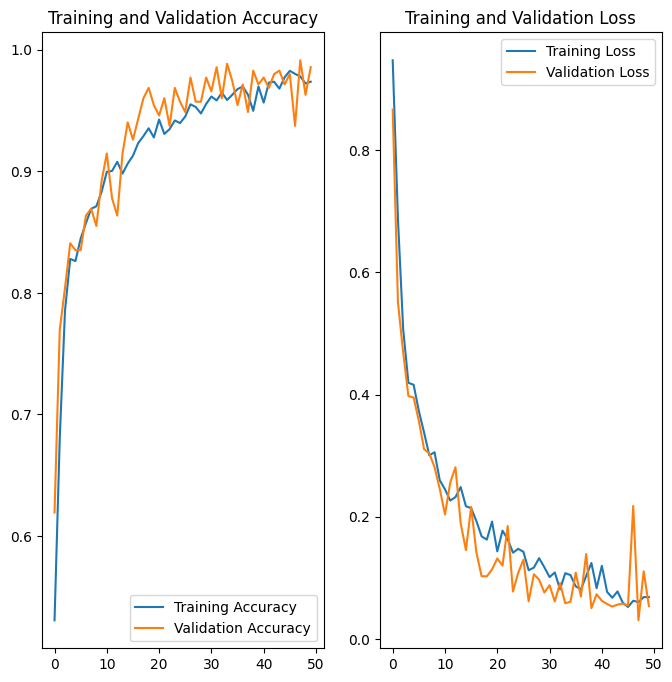

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize =(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc,label='Training Accuracy')
plt.plot(range(epochs),val_acc,label= 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss ,label='Training Loss')
plt.plot(range(epochs),val_loss,label= 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [22]:
history.history['accuracy']

[0.5306341648101807,
 0.6804012656211853,
 0.785381555557251,
 0.8280186057090759,
 0.8262271881103516,
 0.8448584675788879,
 0.8573988080024719,
 0.8692225217819214,
 0.8713722825050354,
 0.8831959962844849,
 0.8996775150299072,
 0.9003941416740417,
 0.9079183340072632,
 0.8982443809509277,
 0.9064851403236389,
 0.912934422492981,
 0.9233250021934509,
 0.9290576577186584,
 0.9355069994926453,
 0.9279828071594238,
 0.942672848701477,
 0.9308491349220276,
 0.9347903728485107,
 0.9419562816619873,
 0.9398065209388733,
 0.9451809525489807,
 0.955213189125061,
 0.953063428401947,
 0.9476889967918396,
 0.9555714726448059,
 0.9616624712944031,
 0.9584378600120544,
 0.9648871421813965,
 0.9587961435317993,
 0.9630956649780273,
 0.9677534699440002,
 0.969903290271759,
 0.9630956649780273,
 0.9498387575149536,
 0.969903290271759,
 0.9566463828086853,
 0.9731279015541077,
 0.9738445281982422,
 0.9681118130683899,
 0.9774274230003357,
 0.9828018546104431,
 0.9802938103675842,
 0.9781440496444702,

# Testing The Model

In [20]:
# Evaluate the model on the testing data
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the testing results
print(f"Test Loss: {(test_loss)*100:.2f}%")
print(f"Test Accuracy: {(test_accuracy)*100:.2f}%")

11/11 [==============================] - 9s 730ms/step - loss: 0.0355 - accuracy: 0.9858
Test Loss: 3.55%
Test Accuracy: 98.58%


# Performance Visualization

## Confusion Matrix

In [52]:
true_labels_test_ds = []
predicted_labels_test_ds = []

# Iterate through the test dataset to make predictions
for images, labels in test_ds:
    predictions = model.predict(images)
    predicted_labels_test_ds.extend(tf.argmax(predictions, axis=1).numpy())
    true_labels_test_ds.extend(labels.numpy())

# Convert true_labels and predicted_probabilities to numpy arrays
true_labels_test_ds = np.array(true_labels_test_ds)
predicted_probabilities_test_ds = np.array(predicted_labels_test_ds)


1/1 [==============================] - 1s 829ms/step


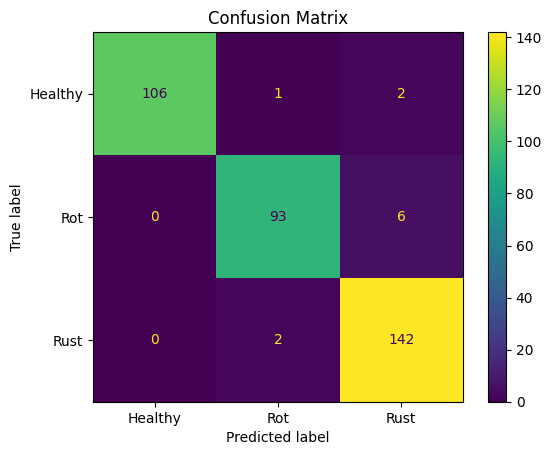

In [53]:
# Create a confusion matrix
cm = confusion_matrix(true_labels_test_ds, predicted_labels_test_ds)

# Display the confusion matrix as a heatmap
class_names = ['Healthy', 'Rot', 'Rust'] 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='viridis', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

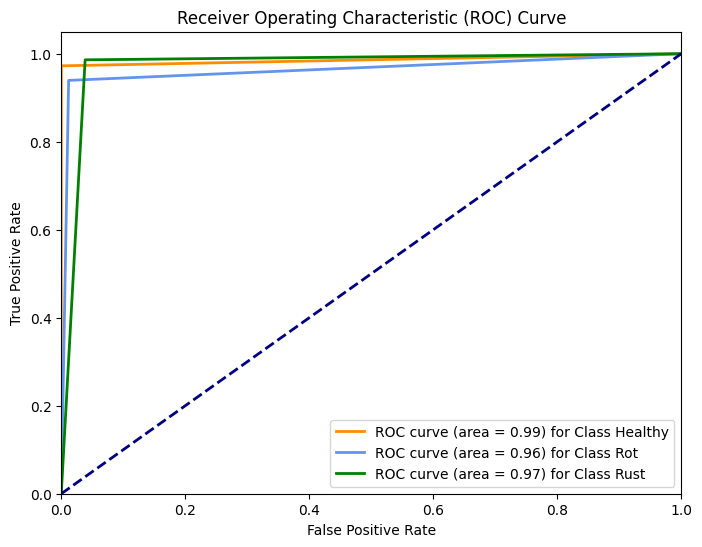

In [55]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
n_classes = len(np.unique(true_labels))

for i in range(n_classes):
    true_labels_one_class = (true_labels_test_ds == i).astype(int)
    predicted_probabilities_one_class = (predicted_probabilities_test_ds == i).astype(int)
    fpr[i], tpr[i], _ = roc_curve(true_labels_one_class, predicted_probabilities_one_class)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
class_names = ['Healthy', 'Rot', 'Rust'] 
colors = ['darkorange', 'cornflowerblue', 'green'] 

for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for Class {class_names[i]}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Precision-Recall Curve

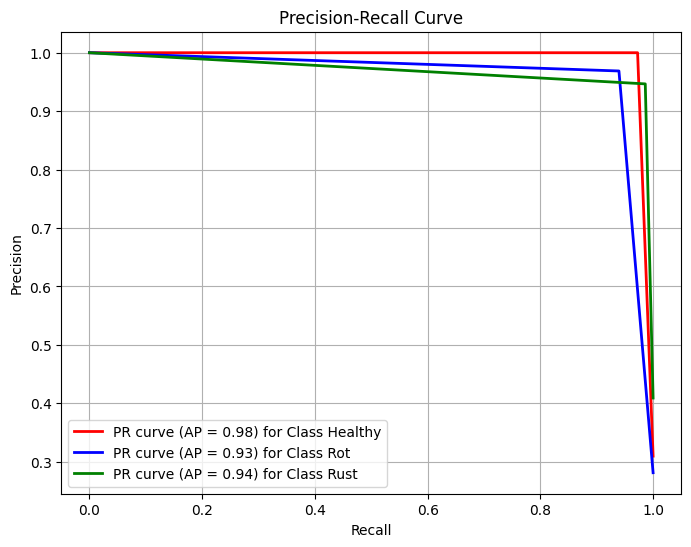

In [66]:
precision = {}
recall = {}
average_precision = {}

# Iterate over each class
for i in range(n_classes):  
    true_labels_one_class = (true_labels_test_ds == i).astype(int)
    predicted_probabilities_one_class = (predicted_probabilities_test_ds == i).astype(int)
    precision[i], recall[i], _ = precision_recall_curve(true_labels_one_class, predicted_probabilities_one_class)
    average_precision[i] = average_precision_score(true_labels_one_class, predicted_probabilities_one_class)

# Plot precision-recall curves for each class
plt.figure(figsize=(8, 6))
class_names = ['Healthy', 'Rot', 'Rust'] 
colors = ['red', 'blue', 'green']  

for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f'PR curve (AP = {average_precision[i]:.2f}) for Class {class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# MODEL PREDICTION

First Image to predict
Actual Label: Rot
1/1 [==============================] - 1s 555ms/step
Predicted Label: Rot


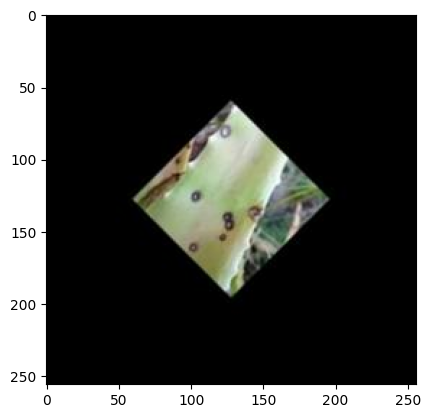

In [72]:
import numpy as np
for images_batch, labels_batchs in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    print("First Image to predict")
    first_image =  plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [68]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)   #create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 80ms/step


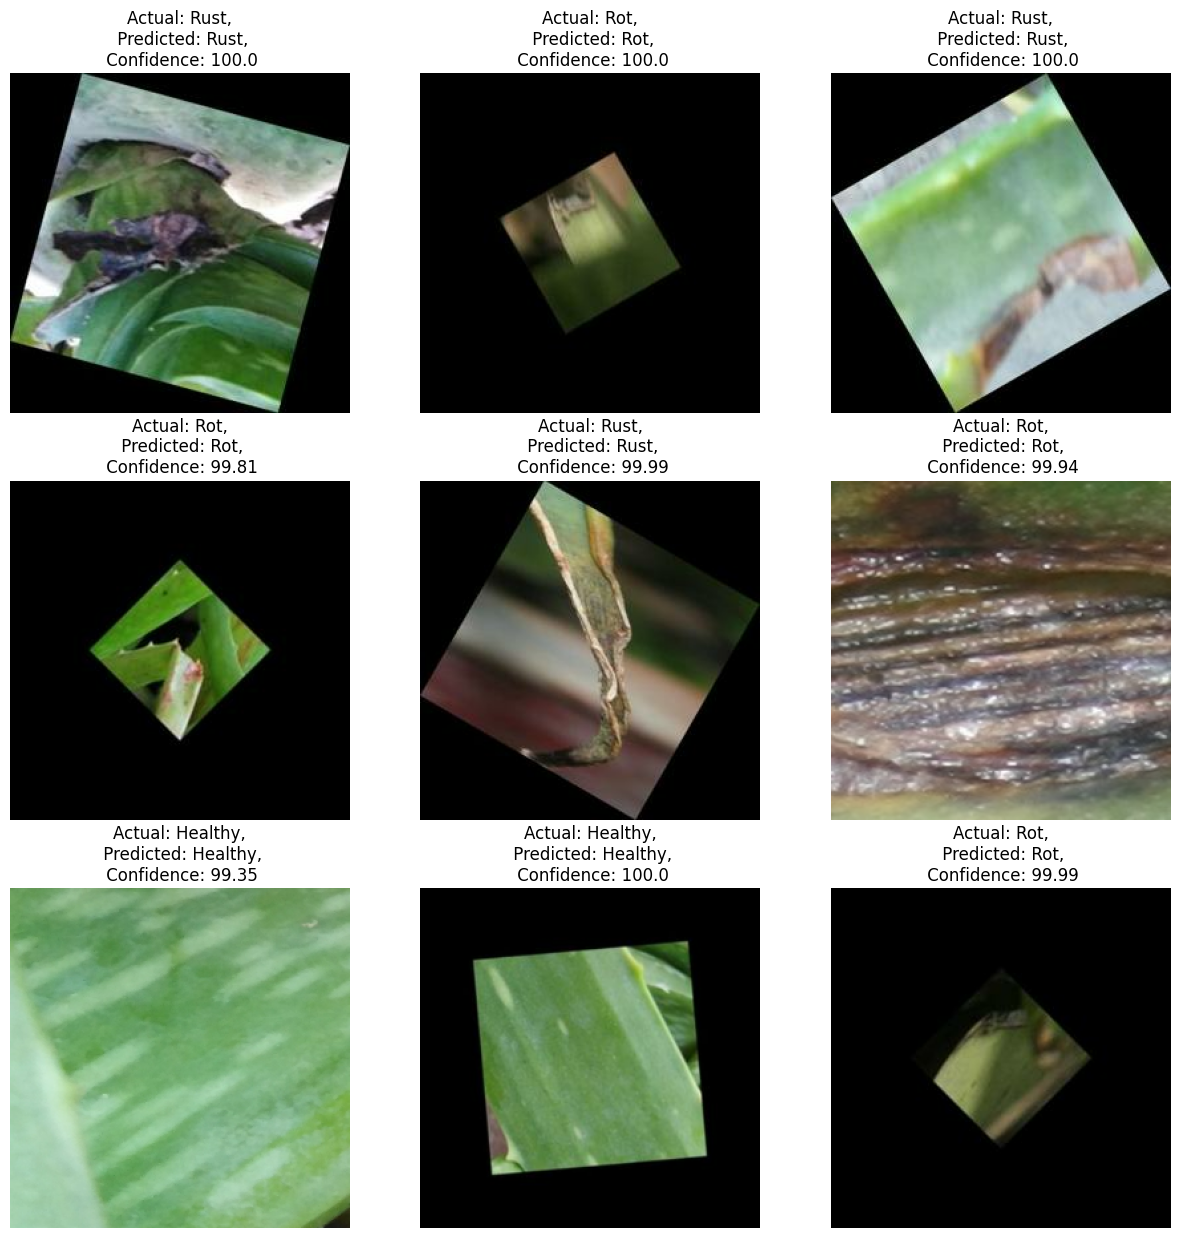

In [73]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence: {confidence}")
        plt.axis('off')

# SAVING MODEL

In [29]:
import os
model_version = max([int(i) for i in (os.listdir("../model")+[0])]) +1
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/4\assets


INFO:tensorflow:Assets written to: ../model/4\assets
